# Project 1

As discussed in class, two groups of asteroid accompanying the planet Jupiter in its orbit around the Sun—the Trojan asteroids. The two groups sit at points of stable equilibrium (the Lagrange points) preceding and trailing Jupiter at an angular distance of π/3 radians. The combination of the gravitational attraction of the Sun and Jupiter gives a resultant force on a Trojan asteroid towards the center of mass of the two bodies such that the centripetal acceleration causes the asteroid to orbit with the same period as the planet.

Note that units suitable for this system are normalized for the Solar System: the mass of the Sun (M⊙) is taken as unit mass, unit distance is the astronomical unit (AU), and unit time is one year. For such a system, the gravitational constant G is 4π2. The mass of Jupiter can be taken to be 0.001 M⊙ and the average distance of Jupiter from the Sun is 5.2 AU. The asteroids' masses are negligible in this system.

In [1]:
import matplotlib    # Library used for plotting
import numpy as np   # Numerical library
import matplotlib.pyplot as plt # Plot commands

import scipy         # Another numerical library
from scipy import integrate

# Define some colors using the RGB format

CF_red = (204/255, 121/255, 167/255)
CF_vermillion = (213/255, 94/255, 0)
CF_orange = (230/255, 159/255, 0)
CF_yellow = (240/255, 228/255, 66/255)
CF_green = (0, 158/255, 115/255)
CF_sky = (86/255, 180/255, 233/255)
CF_blue = (0, 114/255, 178/255)
CF_black = (0, 0, 0)

## Part 1 - Setup

Write a program to solve the equations of motion for this system numerically, and demonstrate that the asteroids will stay at the Lagrange points over many orbits of Jupiter around the Sun. This should show that your program is operating correctly with no numerical instabilities being propagated during the computation.

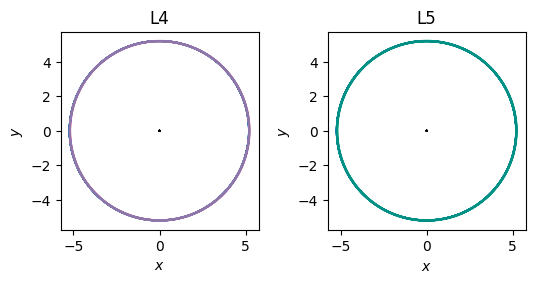

In [52]:
# Parameters
days_J = 4331   # Days per Jupiter year
M_S = 1         # Mass of the Sun
M_J = 0.001     # Mass of Jupiter
radius_J_p2 = 5.2  # Radius of Jupiter's orbit

t_min = 0
t_max = 5 * days_J
epsilon = 1

velocity_J = 2 * np.pi * radius_J_p2 / days_J # Average velocity of Jupiter per day
radius_S = radius_J_p2 * M_J / (M_S + M_J) # Radius of the Sun's orbit
velocity_S = 2 * np.pi * radius_S / days_J # Average velocity of the Sun per day

# position_x_L4 = radius_J * np.cos(np.pi / 3)
# position_y_L4 = radius_J * np.sin(np.pi / 3)
# print(position_x_L4, position_y_L4)

# position_x_L5 = radius_J * np.cos(np.pi / 3)
# position_y_L5 = -radius_J * np.sin(np.pi / 3)
# print(position_x_L5, position_y_L5)

init = np.array([-radius_S, 0, 0, -velocity_S, # Sun
                radius_J_p2, 0, 0, velocity_J, # Jupiter
                2.6, 4.5, (velocity_J * -0.866), (velocity_J * 0.5), # Asteroid L4
                2.6, -4.5, (velocity_J * 0.866), (velocity_J * 0.5)]) # Asteroid L4

# Functions
d = -2.96 * 10 ** (-4) # G * M / AU^3 * 86400^2

def general_derivative(t, state, mass_J):
    x_S, y_S, v_x_S, v_y_S, \
        x_J, y_J, v_x_J, v_y_J, \
        x_A4, y_A4, v_x_A4, v_y_A4, \
        x_A5, y_A5, v_x_A5, v_y_A5 = state

    # Distances
    r_JS = np.sqrt((x_J - x_S) ** 2 + (y_J - y_S) ** 2)  # Distance from Jupiter to Sun
    
    r_A4S = np.sqrt((x_A4 - x_S) ** 2 + (y_A4 - y_S) ** 2)  # Distance from L4 Asteroid to Sun
    r_A4J = np.sqrt((x_A4 - x_J) ** 2 + (y_A4 - y_J) ** 2)  # Distance from L4 Asteroid to Jupiter
    
    r_A5S = np.sqrt((x_A5 - x_S) ** 2 + (y_A5 - y_S) ** 2)  # Distance from L5 Asteroid to Sun
    r_A5J = np.sqrt((x_A5 - x_J) ** 2 + (y_A5 - y_J) ** 2)  # Distance from L5 Asteroid to Jupiter

    # Accelerations
    a_x_SJ =  d * mass_J * (x_S - x_J) / (r_JS ** 3) # Sun's acceleration due to Jupiter
    a_y_SJ =  d * mass_J * (y_S - y_J) / (r_JS ** 3)

    a_x_JS = d * M_S * (x_J - x_S) / (r_JS ** 3)  # Jupiter's acceleration due to the Sun
    a_y_JS = d * M_S * (y_J - y_S) / (r_JS ** 3)

    a_x_A4S = d * M_S * (x_A4 - x_S) / (r_A4S ** 3)  # L4 Asteroid's acceleration due to the Sun
    a_y_A4S = d * M_S * (y_A4 - y_S) / (r_A4S ** 3)
    a_x_A4J = d * mass_J * (x_A4 - x_J) / (r_A4J ** 3)  # L4 Asteroid's acceleration due to Jupiter
    a_y_A4J = d * mass_J * (y_A4 - y_J) / (r_A4J ** 3)
    a_x_A4 = a_x_A4S + a_x_A4J  # Total x acceleration of the L4 Asteroid
    a_y_A4 = a_y_A4S + a_y_A4J  # Total y acceleration of the L4 Asteroid

    a_x_A5S = d * M_S * (x_A5 - x_S) / (r_A5S ** 3)  # L5 Asteroid's acceleration due to the Sun
    a_y_A5S = d * M_S * (y_A5 - y_S) / (r_A5S ** 3)
    a_x_A5J = d * mass_J * (x_A5 - x_J) / (r_A5J ** 3)  # L5 Asteroid's acceleration due to Jupiter
    a_y_A5J = d * mass_J * (y_A5 - y_J) / (r_A5J ** 3)
    a_x_A5 = a_x_A5S + a_x_A5J  # Total x acceleration of the L5 Asteroid
    a_y_A5 = a_y_A5S + a_y_A5J  # Total y acceleration of the L5 Asteroid

    return np.array([v_x_S, v_y_S, a_x_SJ, a_y_SJ, \
                        v_x_J, v_y_J, a_x_JS, a_y_JS, \
                        v_x_A4, v_y_A4, a_x_A4, a_y_A4, \
                        v_x_A5, v_y_A5, a_x_A5, a_y_A5])

# Solution
def derivative(t, state):
    return general_derivative(t, state, M_J)

solution = integrate.solve_ivp(derivative, [t_min, t_max], init, max_step = epsilon)

x_S = solution.y[0]
y_S = solution.y[1]

x_J = solution.y[4]
y_J = solution.y[5]

x_A4 = solution.y[8]
y_A4 = solution.y[9]

x_A5 = solution.y[12]
y_A5 = solution.y[13]

# Plotting
fig, (ax_L4, ax_L5) = plt.subplots(1, 2)
fig.set_size_inches(6, 3)

ax_L4.plot(x_S, y_S, color = CF_black)
ax_L4.plot(x_J, y_J, color = CF_blue)
ax_L4.plot(x_A4, y_A4, color = CF_red, alpha = 0.7)
ax_L4.set(title = "L4", xlabel = "$x$", ylabel = "$y$")
ax_L4.set_aspect("equal")

ax_L5.plot(x_S, y_S, color = CF_black)
ax_L5.plot(x_J, y_J, color = CF_blue)
ax_L5.plot(x_A5, y_A5, color = CF_green, alpha = 0.7)
ax_L5.set(title = "L5", xlabel = "$x$", ylabel = "$y$")
ax_L5.set_aspect("equal")

plt.subplots_adjust(wspace = 0.35)

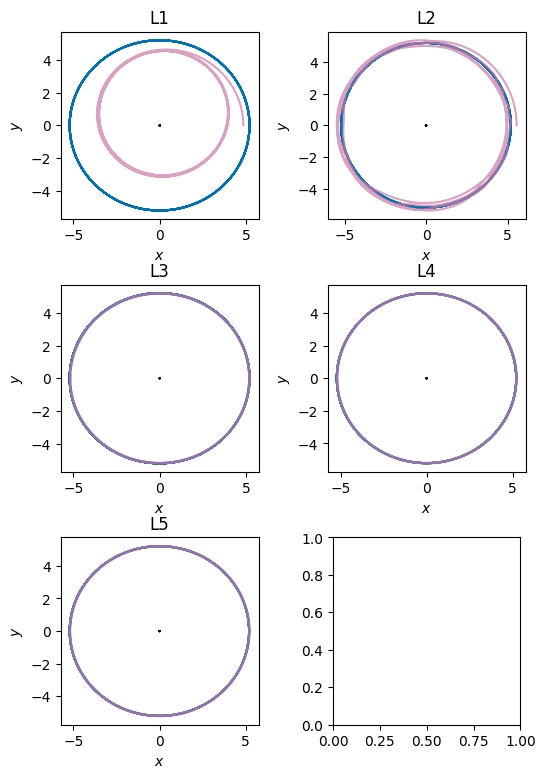

In [48]:
# Parameters
days_J = 4331   # Days per Jupiter year
M_S = 1         # Mass of the Sun
M_J = 0.001     # Mass of Jupiter
radius_J = 5.2  # Radius of Jupiter's orbit

t_min = 0
t_max = 5 * days_J
epsilon = 1

position_L1 = radius_J - 0.3604277601
position_L2 = radius_J + 0.3604277601
position_L3 = -radius_J - 0.003030303 

velocity_J = 2 * np.pi * radius_J / days_J # Average velocity of Jupiter per day
velocity_L1 = 2 * np.pi * position_L1 / days_J 
velocity_L2 = 2 * np.pi * position_L2 / days_J
velocity_L3 = 2 * np.pi * position_L3 / days_J

radius_S = radius_J * M_J / (M_S + M_J)
velocity_S = 2 * np.pi * radius_S / days_J

init_SJ = np.array([-radius_S, 0, 0, -velocity_S, # Sun
                radius_J, 0, 0, velocity_J]) # Jupiter
init_L1 = np.concatenate((init_SJ, np.array([position_L1, 0, 0, velocity_L1]))) 
init_L2 = np.concatenate((init_SJ, np.array([position_L2, 0, 0, velocity_L2]))) 
init_L3 = np.concatenate((init_SJ, np.array([position_L3, 0, 0, velocity_L3]))) 
init_L4 = np.concatenate((init_SJ, np.array([2.6, 4.5, (velocity_J * -0.866), (velocity_J * 0.5)]))) 
init_L5 = np.concatenate((init_SJ, np.array([2.6, -4.5, (velocity_J * 0.866), (velocity_J * 0.5)]))) 

# Functions
d = -2.96 * 10 ** (-4) # G * M / AU^3 * 86400^2

def general_derivative(t, state, mass_J):
    x_S, y_S, v_x_S, v_y_S, x_J, y_J, v_x_J, v_y_J, x_A, y_A, v_x_A, v_y_A = state

    # Distances
    r_JS = np.sqrt((x_J - x_S) ** 2 + (y_J - y_S) ** 2)  # Distance from Jupiter to Sun
    r_AS = np.sqrt((x_A - x_S) ** 2 + (y_A - y_S) ** 2)  # Distance from Asteroid to Sun
    r_AJ = np.sqrt((x_A - x_J) ** 2 + (y_A - y_J) ** 2)  # Distance from Asteroid to Jupiter

    # Accelerations
    a_x_SJ =  d * mass_J * (x_S - x_J) / (r_JS ** 3) # Sun's acceleration due to Jupiter
    a_y_SJ =  d * mass_J * (y_S - y_J) / (r_JS ** 3)

    a_x_JS = d * M_S * (x_J - x_S) / (r_JS ** 3)  # Jupiter's acceleration due to the Sun
    a_y_JS = d * M_S * (y_J - y_S) / (r_JS ** 3)

    a_x_AS = d * M_S * (x_A - x_S) / (r_AS ** 3)  # Asteroid's acceleration due to the Sun
    a_y_AS = d * M_S * (y_A - y_S) / (r_AS ** 3)
    a_x_AJ = d * mass_J * (x_A - x_J) / (r_AJ ** 3)  # Asteroid's acceleration due to Jupiter
    a_y_AJ = d * mass_J * (y_A - y_J) / (r_AJ ** 3)

    a_x_A = a_x_AS + a_x_AJ  # Total x acceleration of the Asteroid
    a_y_A = a_y_AS + a_y_AJ  # Total y acceleration of the Asteroid

    return np.array([v_x_S, v_y_S, a_x_SJ, a_y_SJ, \
                        v_x_J, v_y_J, a_x_JS, a_y_JS, \
                        v_x_A, v_y_A, a_x_A, a_y_A])

# Solution
def derivative(t, state):
    return general_derivative(t, state, M_J)

solution_L1 = integrate.solve_ivp(derivative, [t_min, t_max], init_L1, max_step = epsilon)
solution_L2 = integrate.solve_ivp(derivative, [t_min, t_max], init_L2, max_step = epsilon)
solution_L3 = integrate.solve_ivp(derivative, [t_min, t_max], init_L3, max_step = epsilon)
solution_L4 = integrate.solve_ivp(derivative, [t_min, t_max], init_L4, max_step = epsilon)
solution_L5 = integrate.solve_ivp(derivative, [t_min, t_max], init_L5, max_step = epsilon)

# Plotting
fig, ((ax_L1, ax_L2), (ax_L3, ax_L4), (ax_L5, _)) = plt.subplots(3, 2)
fig.set_size_inches(6, 9)

def plot_orbit(ax, solution, label):
    x_S, y_S = solution.y[0:2]
    x_J, y_J = solution.y[4:6]
    x_A, y_A = solution.y[8:10]

    ax.plot(x_S, y_S, color = CF_black, label = "Sun")
    ax.plot(x_J, y_J, color = CF_blue, label = "Jupiter")
    ax.plot(x_A, y_A, color = CF_red, label = label, alpha = 0.7)
    ax.set(title = label, xlabel = "$x$", ylabel = "$y$")
    plt.gca().set_aspect("equal")
    
plot_orbit(ax_L1, solution_L1, "L1")
plot_orbit(ax_L2, solution_L2, "L2")
plot_orbit(ax_L3, solution_L3, "L3")
plot_orbit(ax_L4, solution_L4, "L4")
plot_orbit(ax_L5, solution_L5, "L5")

plt.subplots_adjust(wspace = 0.35, hspace = 0.35)

## Part 2 - Position Stability

Vary the initial positions of the asteroids and plot their positions through a few hundred orbits. Your results should show that they oscillate about the Lagrange points, but do not escape from the stable position. Considering both the leading and trailing groups, determine a way to quantitatively describe how far the stable orbits wander from the Lagrange points. Plot their wander as a function of their initial position perturbation.

In [53]:
def wander(exact_solution, varied_solution):
    X_L4_diff = varied_solution.y[8] - exact_solution.y[8]
    Y_L4_diff = varied_solution.y[9] - exact_solution.y[9]

    X_L5_diff = varied_solution.y[12] - exact_solution.y[12]
    Y_L5_diff = varied_solution.y[13] - exact_solution.y[13]
    
    wander_distance_L4 = np.sqrt(X_L4_diff ** 2 + Y_L4_diff ** 2)
    wander_distance_L5 = np.sqrt(X_L5_diff ** 2 + Y_L5_diff ** 2)

    return wander_distance_L4, wander_distance_L5

In [62]:
# Wander from center/jupiter/sun
def wander(solution):
    X_sun = solution.y[0]
    Y_sun = solution.y[1]

    X_L4 = solution.y[8]
    Y_L4 = solution.y[9]

    X_L5 = solution.y[12]
    Y_L5 = solution.y[13]

    wander_distance_L4 = np.sqrt((X_L4 - X_sun) ** 2 + (Y_L4 - Y_sun) ** 2) - 5.2
    wander_distance_L5 = np.sqrt((X_L5 - X_sun) ** 2 + (Y_L5 - Y_sun) ** 2) - 5.2

    return wander_distance_L4, wander_distance_L5

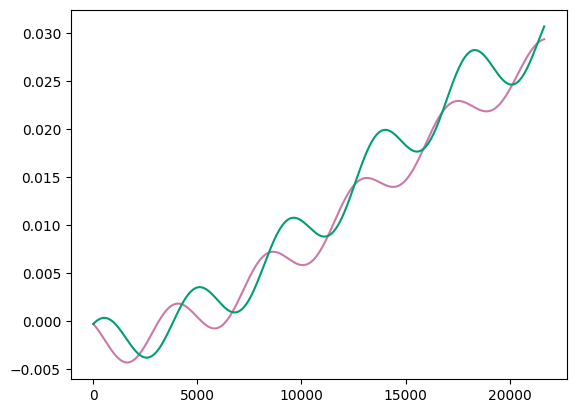

In [63]:
# Changing the radius of Jupiter's orbit
radius_J_p2 = 5.2

position_x_L4 = radius_J_p2 * np.cos(np.pi / 3)
position_y_L4 = radius_J_p2 * np.sin(np.pi / 3)

position_x_L5 = radius_J_p2 * np.cos(np.pi / 3)
position_y_L5 = -radius_J_p2 * np.sin(np.pi / 3)

init_p2 = np.array([-radius_S, 0, 0, -velocity_S, # Sun
                radius_J, 0, 0, velocity_J, # Jupiter
                position_x_L4, position_y_L4, (velocity_J * -0.866), (velocity_J * 0.5), # Asteroid L4
                position_x_L5, position_y_L5, (velocity_J * 0.866), (velocity_J * 0.5)]) # Asteroid L4

solution = integrate.solve_ivp(derivative, [t_min, t_max], init, max_step = epsilon)
fig, ax = plt.subplots(1, 1)
wander_distance_L4, wander_distance_L5 = wander(solution)
ax.plot(solution.t, wander_distance_L4, color = CF_red, label = "L4")
ax.plot(solution.t, wander_distance_L5, color = CF_green, label = "L5")


# num_steps = 5 * days_J
# t_points = np.linspace(t_min, t_max, num_steps)
# solution = integrate.solve_ivp(derivative, [t_min, t_max], init, t_eval = t_points, max_step = epsilon)
# solution_p2 = integrate.solve_ivp(derivative, [t_min, t_max], init_p2, t_eval = t_points, max_step = epsilon)
# wander_distance_L4, wander_distance_L5 = wander(solution, solution_p2)

# fig, ax = plt.subplots(1, 1)
# ax.plot(t_points, wander_distance_L4, color = CF_red, label = "L4")
# ax.plot(t_points, wander_distance_L5, color = CF_green, label = "L5")

## Part 3 - Velocity Stability

Give your particles some initial velocity relative to the Lagrange points. Determine the range of initial velocity vectors for which the orbits remain captured by the Lagrange points. 

## Part 4 - Mass Dependence

Similar "Trojan" asteroids are also present in the orbit of Mars. Run your program for a range of planetary masses (within two orders of magnitude of Jupiter's mass should work). Explore the range of distances that the asteroids wander as a function of the planetary mass.